# Model for single mode squeezed vacuum

We test the boson sampling operator (no training) 
on coherent states

We compare with theory

nonlinearxwaves@gmail.com<br>
@created 27 gennaio 2021<br>
@version 8 gennaio 2022<br>

In [1]:
import numpy as np
import math
from thqml import phasespace as ps
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2023-05-03 18:23:40.140783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-03 18:23:40.140806: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [3]:
tf.keras.backend.clear_session()

In [4]:
np.set_printoptions(precision=2)

## Dimension

In [5]:
N = 2

## Build vacuum by the Gaussian state

In [6]:
vacuum = ps.VacuumLayer(N)

2023-05-03 18:23:48.497083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-03 18:23:48.497151: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-03 18:23:48.497213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist
2023-05-03 18:23:48.498684: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Squeezer for mode 0

In [7]:
r_np=0.8;
theta_np=np.pi/4;
squeezer=ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=0)

## Build the model

In [8]:
xin = tf.keras.layers.Input(N)
x1, a1 = squeezer(xin)
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

# Evaluate the covariance

In [9]:
cov_layer = ps.covariance(N)
covariance_matrix, mean_R, hessian = cov_layer(chir,chii, model)
squeezed_cov = tf.keras.Model(inputs = xin, outputs=[covariance_matrix, mean_R, hessian])
xtrain = np.random.rand(1, N)-0.5
cov0,d0, hessian0=squeezed_cov(xtrain); print(d0); tf.print(cov0)

tf.Tensor([[0. 0.]], shape=(1, 2), dtype=float32)
[[0.897684276 -1.67978024]
 [-1.67978024 4.25724459]]


# Evaluate the Qtransform with calculated covariance and displacemente

In [10]:
Qrho = ps.QTransform(cov0, d0)

In [11]:
# test the call to the Q-trasform
kin = tf.zeros_like(d0)
Qrho(kin)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.75]], dtype=float32)>

# Test the Pr operator 

Probability of zero photon

In [12]:
ps.Pr([0], Qrho)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.75]], dtype=float32)>

Probability of one photon

In [13]:
ps.Pr([1], Qrho)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.49e-08], dtype=float32)>

Probability of two photons

In [14]:
ps.Pr([2], Qrho)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.16], dtype=float32)>

## Define a function with the expected theoretical value

In [15]:
def Psqueeze(n, r):
    # returh the theory value for the Boson sampling for coherent states
    
    scale = 1.0
    if n % 2 ==0 :
        scale = scale/np.cosh(r)
        scale = scale*np.power(np.tanh(r), n)
        scale = scale*np.math.factorial(n)
        scale = scale/np.power(2.0,n)
        n2 = n/2
        scale = scale/np.power(np.math.factorial(n2),2)
    else:
        scale = 0.0
    
    return scale   

## Make a plot versus the probability

In [16]:
nmax=6
Pn = np.zeros([nmax,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(nmax):
    print('Computing Pn at n '+repr(nbar))
    Pn[nbar]=ps.Pr([nbar],Qrho).numpy()
    Pth[nbar]=Psqueeze(nbar,r_np)
    xaxis[nbar]=nbar
print('Done')

Computing Pn at n 0
Computing Pn at n 1
Computing Pn at n 2
Computing Pn at n 3
Computing Pn at n 4
Computing Pn at n 5
Done


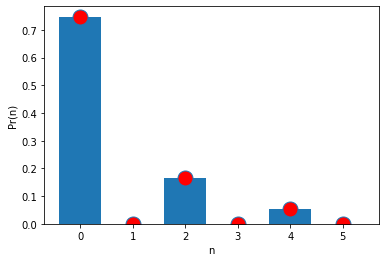

In [17]:
plt.bar(xaxis,Pn)
plt.plot(xaxis, Pth, marker='o', markersize=15, markerfacecolor='red', linestyle='none')
plt.xlabel('n');
plt.ylabel('Pr(n)');
# save in a figure
plt.savefig('BosonSamplingExample2.pdf', format='pdf')

Comparison between the photon number evaluated with the model(bars) and the theory (red dots)